# ***Install libraries***

In [1]:
!pip install -q timm seaborn scikit-learn

# ***Mount Google Drive***

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# ***IMPORTS***

In [3]:
import os
import random
import copy
import numpy as np

import torch
import torch.nn as nn
import timm

import matplotlib.pyplot as plt
import seaborn as sns

from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


# ***USER VARIABLES***

In [4]:
TRAIN_DIR = "/content/drive/MyDrive/Project work/Dataset/Epic and CSCR hospital Dataset_clean/Train"
TEST_DIR  = "/content/drive/MyDrive/Project work/Dataset/Epic and CSCR hospital Dataset_clean/Test"
SAVE_PATH = "/content/drive/MyDrive/Project work/models/TinyViT_MRI_FINAL.pth"

IMG_SIZE = 224
BATCH_SIZE = 16

TARGET_ACCURACY = 0.92
PATIENCE = 4

WARMUP_EPOCHS = 3
HEAD_EPOCHS   = 4
PARTIAL_EPOCHS = 6
FULL_EPOCHS    = 6

LR_HEAD    = 3e-4
LR_PARTIAL = 3e-5
LR_FULL    = 1e-5


# ***Reproducibility***

In [5]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = True

device = "cuda" if torch.cuda.is_available() else "cpu"
print("GPU:", torch.cuda.get_device_name(0))

scaler = torch.cuda.amp.GradScaler()


GPU: NVIDIA L4


/tmp/ipython-input-4291952154.py:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


# ***Transforms***

In [6]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.90,1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])


# ***Dataset***

In [7]:
full_train = datasets.ImageFolder(TRAIN_DIR, transform=train_transform)
class_names = full_train.classes
NUM_CLASSES = len(class_names)

train_size = int(0.8 * len(full_train))
val_size   = len(full_train) - train_size

train_ds, val_ds = random_split(
    full_train,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(SEED)
)

test_ds = datasets.ImageFolder(TEST_DIR, transform=test_transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("Classes:", class_names)


Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


# ***Class Weights***

In [8]:
from collections import Counter

targets = [s[1] for s in full_train.samples]
cnt = Counter(targets)

weights = torch.tensor(
    [len(targets)/cnt[i] for i in range(NUM_CLASSES)],
    dtype=torch.float
).to(device)

criterion = nn.CrossEntropyLoss(weight=weights, label_smoothing=0.1)


# ***Model***

In [9]:
model = timm.create_model(
    "vit_tiny_patch16_224",
    pretrained=True,
    num_classes=NUM_CLASSES,
    drop_rate=0.1,
    drop_path_rate=0.15
).to(device)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

# ***Training Engine***

In [10]:
class Trainer:

    def __init__(self, model):
        self.model = model
        self.best_acc = 0
        self.best_state = None
        self.no_improve = 0

        self.history = {
            "train_loss": [],
            "val_loss": [],
            "train_acc": [],
            "val_acc": []
        }

    def freeze_backbone(self, freeze):
        if freeze:
            for name, p in self.model.named_parameters():
                if "head" not in name:
                    p.requires_grad = False
        else:
            for p in self.model.parameters():
                p.requires_grad = True

    def run_epoch(self, loader, optimizer=None, train=True):

        self.model.train() if train else self.model.eval()

        total_loss = 0
        correct = 0
        total = 0

        for imgs, labels in loader:

            imgs = imgs.to(device)
            labels = labels.to(device)

            if train:
                optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                outputs = self.model(imgs)
                loss = criterion(outputs, labels)

            if train:
                scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(),1.0)
                scaler.step(optimizer)
                scaler.update()

            total_loss += loss.item()
            _, pred = outputs.max(1)
            total += labels.size(0)
            correct += pred.eq(labels).sum().item()

        return total_loss/len(loader), correct/total

    def train_stage(self, name, epochs, lr, freeze):

        print("\n====", name, "====")

        self.freeze_backbone(freeze)

        optimizer = torch.optim.AdamW(
            filter(lambda p:p.requires_grad, self.model.parameters()),
            lr=lr,
            weight_decay=0.05
        )

        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=epochs,
            eta_min=1e-6
        )

        for epoch in range(epochs):

            train_loss, train_acc = self.run_epoch(train_loader, optimizer, True)
            val_loss, val_acc     = self.run_epoch(val_loader, None, False)

            scheduler.step()

            print(f"Epoch {epoch+1}/{epochs}  Train:{train_acc*100:.2f}%  Val:{val_acc*100:.2f}%")

            # save history
            self.history["train_loss"].append(train_loss)
            self.history["val_loss"].append(val_loss)
            self.history["train_acc"].append(train_acc*100)
            self.history["val_acc"].append(val_acc*100)

            if val_acc > self.best_acc:
                self.best_acc = val_acc
                self.best_state = copy.deepcopy(self.model.state_dict())
                self.no_improve = 0
            else:
                self.no_improve += 1

            if self.best_acc >= TARGET_ACCURACY:
                print("Target accuracy reached.")
                return True

            if self.no_improve >= PATIENCE:
                print("Early stopping.")
                return True

        return False


# ***Training***

In [11]:
trainer = Trainer(model)

if not trainer.train_stage("Warmup", WARMUP_EPOCHS, LR_HEAD, True):
    if not trainer.train_stage("Head Training", HEAD_EPOCHS, LR_HEAD, True):
        if not trainer.train_stage("Partial Finetune", PARTIAL_EPOCHS, LR_PARTIAL, False):
            trainer.train_stage("Full Finetune", FULL_EPOCHS, LR_FULL, False)

model.load_state_dict(trainer.best_state)
print("Best Validation Accuracy:", trainer.best_acc*100)



==== Warmup ====


/tmp/ipython-input-333177122.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/3  Train:53.77%  Val:78.96%
Epoch 2/3  Train:64.88%  Val:82.07%
Epoch 3/3  Train:66.65%  Val:81.61%

==== Head Training ====
Epoch 1/4  Train:67.63%  Val:82.02%
Epoch 2/4  Train:67.76%  Val:83.58%
Epoch 3/4  Train:68.63%  Val:83.78%
Epoch 4/4  Train:69.46%  Val:83.73%

==== Partial Finetune ====
Epoch 1/6  Train:82.07%  Val:94.56%
Target accuracy reached.
Best Validation Accuracy: 94.55958549222798


# ***GRAPHS***

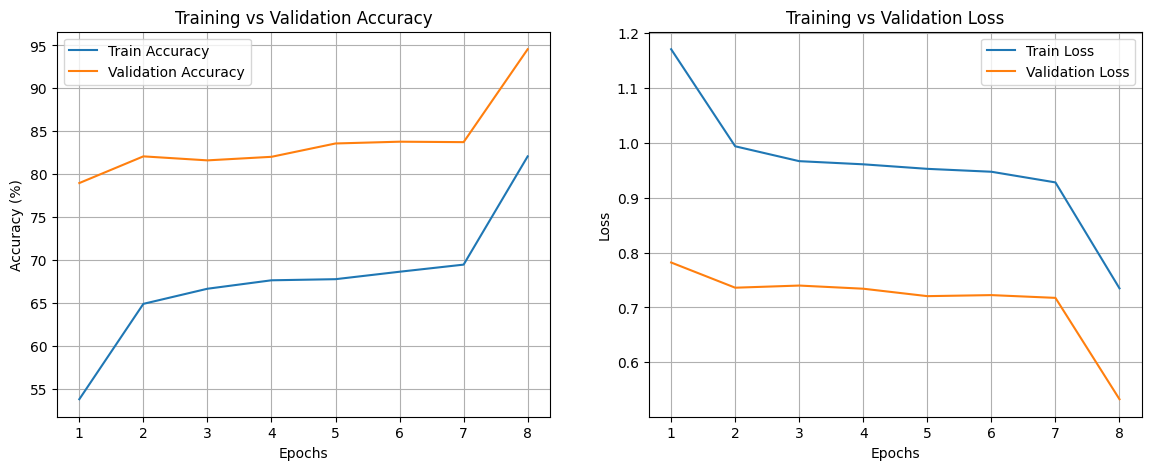

In [12]:
epochs_range = range(1, len(trainer.history["train_loss"]) + 1)

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(epochs_range, trainer.history["train_acc"], label="Train Accuracy")
plt.plot(epochs_range, trainer.history["val_acc"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(epochs_range, trainer.history["train_loss"], label="Train Loss")
plt.plot(epochs_range, trainer.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)

plt.show()


# ***Evaluation***

In [13]:
model.eval()

y_true=[]
y_pred=[]

with torch.no_grad():
    for imgs, labels in test_loader:
        outputs = model(imgs.to(device))
        _, pred = outputs.max(1)
        y_true += labels.numpy().tolist()
        y_pred += pred.cpu().numpy().tolist()


# ***Confusion Matrix + Report***

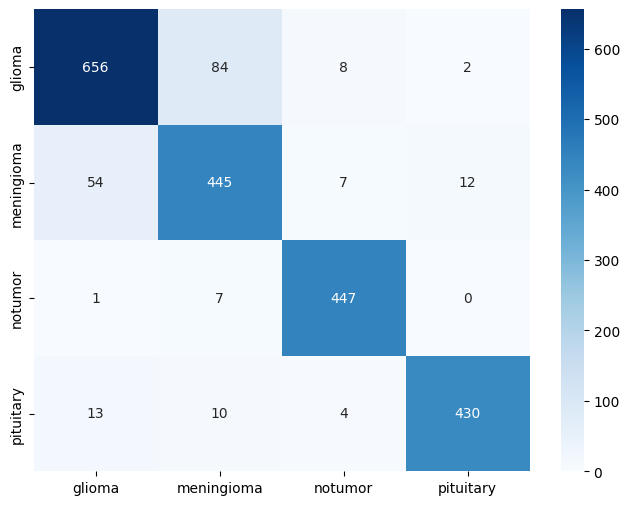

              precision    recall  f1-score   support

      glioma       0.91      0.87      0.89       750
  meningioma       0.82      0.86      0.84       518
     notumor       0.96      0.98      0.97       455
   pituitary       0.97      0.94      0.95       457

    accuracy                           0.91      2180
   macro avg       0.91      0.91      0.91      2180
weighted avg       0.91      0.91      0.91      2180

Test Accuracy: 90.73394495412845


In [14]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_names,
            yticklabels=class_names,
            cmap="Blues")
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names))
print("Test Accuracy:", np.mean(np.array(y_true)==np.array(y_pred))*100)


# ***Save Model***

In [15]:
torch.save(model.state_dict(), SAVE_PATH)
print("Model saved to:", SAVE_PATH)


Model saved to: /content/drive/MyDrive/Project work/models/TinyViT_MRI_FINAL.pth
